In [1]:
import os
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.nn import sigmoid, relu
from jax.tree_util import tree_map

import optax
import functools

import torch
from torch.utils import data

In [2]:
import matplotlib.pyplot as plt

In [3]:
import util as U

# Load data

In [4]:
iwave = 0

In [5]:
_thetas, _t_ages = [], [] 
for i in range(10): 
    _thetas.append(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.thetas_sps.npz' % i))['arr_0'])
    _t_ages.append(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.tages.npz' % i))['arr_0'])    
_thetas = np.concatenate(_thetas, axis=0)    
_t_ages = np.concatenate(_t_ages, axis=0)
_thetas = np.concatenate([_thetas, _t_ages[:,None]], axis=1)

In [6]:
avg_thetas = np.mean(_thetas, axis=0)
std_thetas = np.std(_thetas, axis=0)
thetas = (_thetas - avg_thetas)/std_thetas

In [7]:
_x_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.x_pca.w%i.npy' % iwave))

In [8]:
avg_x_pca = np.mean(_x_pca, axis=0)
std_x_pca = np.std(_x_pca, axis=0)
x_pca = (_x_pca - avg_x_pca)/std_x_pca

In [9]:
def numpy_collate(batch):
    return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.ravel(np.array(pic, dtype=jnp.float32))

In [10]:
N_train = int(0.9*x_pca.shape[0])
train_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[:N_train]), torch.tensor(x_pca[:N_train])), batch_size=500)
valid_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[N_train:]), torch.tensor(x_pca[N_train:])), batch_size=500)

# set up MLP in jax

In [11]:
def nonlin_act(x, beta, gamma):
    return (gamma + sigmoid(beta * x) * (1 - gamma)) * x

def init_mlp_params(layer_sizes, scale=1e-2):
    keys = random.split(random.PRNGKey(1), len(layer_sizes))

    params = []
    for i, key in zip(np.arange(len(layer_sizes)-2), keys): 
        m, n = layer_sizes[i], layer_sizes[i+1]
        #w_key, b_key = random.split(key, num=2)
        #params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
        w_key, b_key, _a_key, _b_key = random.split(key, num=4)
        params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,)), 
                      scale * random.normal(_a_key, (n,)), scale * random.normal(_b_key, (n,))])

    m, n = layer_sizes[-2], layer_sizes[-1]        
    w_key, b_key = random.split(keys[-1], num=2)
    params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
    return params

@functools.partial(jax.vmap, in_axes=(None, 0))
def forward(params, inputs):
    activations = inputs
    #for w, b in params[:-1]:
    for w, b, beta, gamma in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = nonlin_act(outputs, beta, gamma) #relu(outputs)#

    final_w, final_b = params[-1]
    return jnp.dot(final_w, activations) + final_b

def mse_loss(params, inputs, targets):
    preds = forward(params, inputs)
    return jnp.mean((preds - targets) ** 2)

# train using `optax`

In [12]:
# Update function
@jit
def update(params, opt_state, inputs, targets):
    loss, grads = jax.value_and_grad(mse_loss)(params, inputs, targets)
    updates, opt_state = gradient_transform.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    #updates, opt_state = optimizer.update(grads, opt_state)
    #params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [13]:
layer_sizes = [thetas.shape[1], 512, 512, 512, x_pca.shape[1]]
learning_rate = 1e-2
n_epochs = 1000

# Initialize the MLP and optimizer
params = init_mlp_params(layer_sizes)
optimizer = optax.adam(learning_rate)

total_steps = n_epochs*len(train_dataloader)
scheduler = optax.exponential_decay(init_value=learning_rate, 
                                    transition_steps=total_steps, 
                                    transition_begin=int(total_steps*0.25),
                                    decay_rate=0.01)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

# Initialize optimizer state
#opt_state = optimizer.init(params)
opt_state = gradient_transform.init(params)


# Training loop
train_loss, valid_loss, best_valid_loss, best_epoch = [], [], np.inf, 0
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x, y in train_dataloader:        
        params, opt_state, loss = update(params, opt_state, x, y)        
        epoch_loss += loss
    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)
    
    _loss = 0.
    for x, y in valid_dataloader: 
        loss = mse_loss(params, x, y)
        _loss += loss
    valid_loss.append(_loss/len(valid_dataloader))

    # early stopping after 20 epochs
    if valid_loss[-1] < best_valid_loss: 
        best_valid_loss = valid_loss[-1]
        best_epoch = epoch
        best_params = params.copy()

    if epoch > best_epoch + 20: 
        break

    if epoch % 10 == 0: print(f"Epoch {epoch}, Loss: {epoch_loss}, Valid Loss: {valid_loss[-1]}")

2024-04-24 13:35:26.970019: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Epoch 0, Loss: 0.4170221984386444, Valid Loss: 0.28953492641448975
Epoch 10, Loss: 0.1890556514263153, Valid Loss: 0.20912723243236542
Epoch 20, Loss: 0.17358824610710144, Valid Loss: 0.1839834600687027
Epoch 30, Loss: 0.165710911154747, Valid Loss: 0.17988955974578857
Epoch 40, Loss: 0.15929654240608215, Valid Loss: 0.16957548260688782
Epoch 50, Loss: 0.15583133697509766, Valid Loss: 0.1708892434835434
Epoch 60, Loss: 0.15214858949184418, Valid Loss: 0.17519408464431763
Epoch 70, Loss: 0.1504860669374466, Valid Loss: 0.16698363423347473
Epoch 80, Loss: 0.14906500279903412, Valid Loss: 0.1674344837665558
Epoch 90, Loss: 0.14733125269412994, Valid Loss: 0.17235144972801208
Epoch 100, Loss: 0.14606229960918427, Valid Loss: 0.15543347597122192
Epoch 110, Loss: 0.14473222196102142, Valid Loss: 0.15642310678958893


In [14]:
forward(best_params, np.array([thetas[0]]))

Array([[-0.56091994,  0.88924736,  0.3619088 ,  0.7454902 , -0.44242644,
         0.12411431,  0.28678083, -0.6890594 , -0.2523253 ,  0.08695175,
         0.27240872,  0.20032182,  0.01110237, -0.20499788, -1.0869149 ,
         0.186796  ,  0.34250808,  0.20598796,  0.005796  , -0.47171068,
        -0.62958646, -0.92534405, -0.14382401,  0.46953252, -0.3251682 ,
        -0.17502408, -0.06687029, -0.45333362, -0.18832439, -0.28265935,
         0.22353911, -0.91884446,  0.46970698, -0.16763955,  0.12033338,
         0.19131447,  0.08373158,  0.58300906,  0.4946722 , -0.5729561 ,
        -0.1918095 ,  0.42023435, -0.36499807,  0.4007348 ,  0.6939702 ,
        -0.10628666, -0.03386442, -0.37501183, -0.15412545,  0.2069335 ]],      dtype=float32)

In [15]:
x_pca[0]

array([-0.54183308,  0.903849  ,  0.35833175,  0.74715039, -0.49139876,
        0.12673041,  0.34411543, -0.68580947, -0.36211738,  0.12033735,
        0.10623032,  0.11843953,  0.12138415, -0.15936403, -1.03258514,
        0.12819094,  0.44048624,  0.21458756, -0.01613224, -0.42981134,
       -0.58419217, -0.91268515, -0.08356222,  0.42269231, -0.32774002,
       -0.20316892, -0.08100052, -0.57434618, -0.12659601, -0.39018885,
        0.08950705, -0.97297941,  0.6065888 , -0.09499975,  0.02730038,
        0.25482791, -0.04344216,  0.53033247,  0.53242387, -0.6407962 ,
       -0.03348228,  0.41607369, -0.30245498,  0.34658066,  0.62266106,
       -0.06754308, -0.12947285, -0.36288769, -0.30495337,  0.0879292 ])

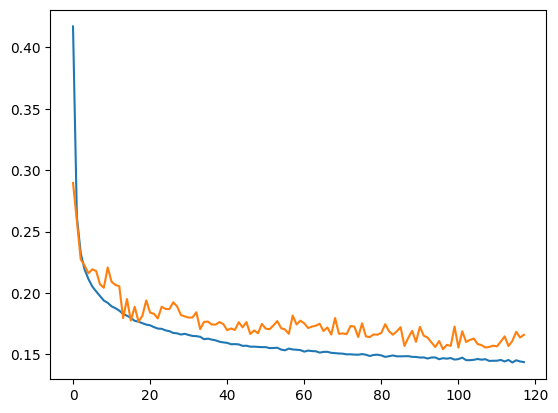

In [16]:
plt.plot(train_loss)
plt.plot(valid_loss)

# validate trained NN

In [17]:
M_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.M_pca.w%i.npy' % iwave))
avg_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.avg_logseds.w%i.npy' % iwave))
std_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.std_logseds.w%i.npy' % iwave))

In [18]:
wave_bins = [(1.5e3, 3.525e3), 
             (3.525e3, 5.5e3), (5.5e3, 7.5e3), # these wavelength ranges are determined by the MILES spectral library wavelength (3525 - 7500)
             (7.5e3, 4e5)]
wave_bin = wave_bins[iwave]

_w = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.0.waves.npz'))['arr_0'][0]
wlim = np.ones(len(_w)).astype(bool)
if wave_bin[0] is not None: wlim &= (_w > wave_bin[0])
if wave_bin[1] is not None: wlim &= (_w < wave_bin[1])   
    
theta_test = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.999.thetas_sps.npz'))['arr_0']
t_age_test = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.999.tages.npz'))['arr_0']
logsed = np.log10(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.999.seds.npz'))['arr_0'][:,wlim])

In [19]:
dlogsed = []
for i in range(logsed.shape[0]): 
    _theta = np.concatenate([theta_test[i], [t_age_test[i]]])
    _wtheta = (_theta - avg_thetas)/std_thetas

    _y_pred = forward(best_params, np.array([_wtheta]))

    _y_pred *= std_x_pca
    _y_pred += avg_x_pca

    _logsed_pred = np.dot(_y_pred, M_pca) * std_logsed + avg_logsed
    dlogsed.append((10**logsed[i] - 10**_logsed_pred)/10**logsed[i])

(-0.5, 0.5)

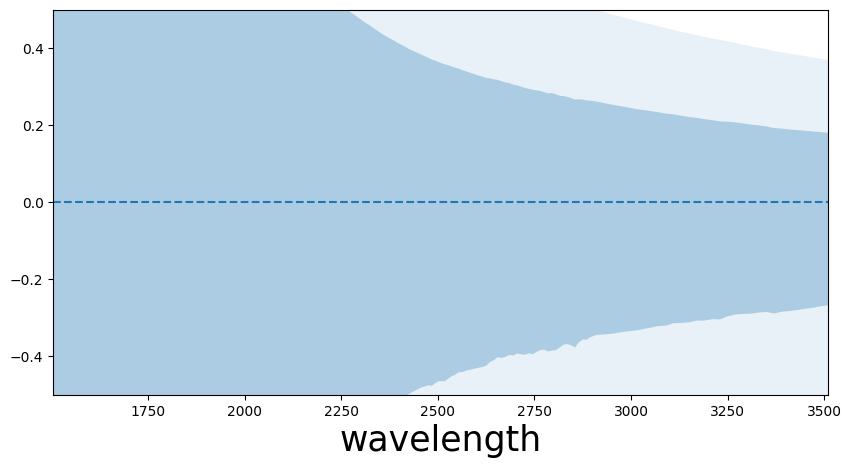

In [21]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

q0, q1, q2, q3 = np.quantile(dlogsed, [0.025, 0.16, 0.84, 0.975], axis=0)


sub.fill_between(_w[wlim], q0[0], q3[0], color='C0', edgecolor='none', alpha=0.1) 
sub.fill_between(_w[wlim], q1[0], q2[0], color='C0', edgecolor='none', alpha=0.3) 
sub.plot([_w[wlim].min(), _w[wlim].max()], [0., 0.], c='C0', ls='--')

sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(_w[wlim].min(), _w[wlim].max())

sub.set_ylim(-0.5, 0.5)